In [50]:
from pathlib import Path
import xarray as xr
import scipy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import mtrf

In [ ]:
data_path = Path("../data")
ds = xr.open_dataset(data_path/"data.nc")

In [ ]:
ds

In [ ]:
ds.response.shape

In [ ]:
ds.regressor.shape

In [ ]:
X = ds.regressor.values

max_lag = 50 #range of lag
n = len(X)
X_lagged = np.zeros((n, max_lag))
for lag in range(max_lag):
    X_lagged[lag:, lag] = X[:n-lag]

In [ ]:
X_lagged.shape

In [ ]:
plt.imshow(X_lagged[:1000, :], aspect="auto")

In [ ]:
y = ds.response.values
plt.plot(y[:1000]);

In [ ]:
intercept_col = np.ones((X.shape[0],1))
intercept_col

In [ ]:
X_lagged = np.hstack((intercept_col,X_lagged))
X_lagged.shape

In [ ]:
b = np.linalg.solve(X_lagged.T @ X_lagged, X_lagged.T @ y)

In [ ]:
plt.plot(b[1:]);

In [ ]:
# %%timeit
lam = 0.1 # you can get the best value for lambda from cross-validation
b_ridge = np.linalg.solve(X_lagged.T @ X_lagged + lam * np.eye(X_lagged.shape[1]), X_lagged.T @ y)

In [ ]:
b_ridge.shape

In [ ]:
plt.plot(b_ridge[1:]);

In [ ]:
X.shape

In [ ]:
b_ridge.shape

In [ ]:
y_pred = np.zeros(y.shape)
for i in range(y.shape[1]):
    y_pred[:, i] = np.convolve(X, b_ridge[1:, i], mode="full")[:n] + b_ridge[0, i]


In [ ]:
# plt.plot(y[:,1])
plt.plot(y_pred[100:200,1])

In [ ]:
y_z = (y - y.mean(axis=0)) / y.std(axis=0)
yp_z = (y_pred - y_pred.mean(axis=0)) / y_pred.std(axis=0)
r = (y_z * yp_z).mean(axis=0)
r


In [ ]:
idx = np.argmax(r)
plt.plot(y[:, idx])
plt.plot(y_pred[:, idx])

In [ ]:
plt.plot(b_ridge[1:, idx])

In [54]:
trf = mtrf.TRF()
tmin, tmax = 0, 1  # range of time lag
regularization = 0.1 # regularization parameter lambda
fs = ds.fs
trf.train(X, y, fs, tmin, tmax, regularization)

In [58]:
X_split = np.array_split(X, 10)
y_split = np.array_split(y, 10)
regularization = [0.001, 0.01, 0.1, 1, 10, 100]
trf.train(X_split, y_split, fs, tmin, tmax, regularization)

Cross-validating[##################################################] 10/10....] 0/6

Cross-validating[##################################################] 10/10....] 1/6

Cross-validating[##################################################] 10/10....] 2/6

Cross-validating[##################################################] 10/10....] 3/6

Cross-validating[##################################################] 10/10....] 4/6

Cross-validating[##################################################] 10/10....] 5/6

Hyperparameter optimization[##################################################] 6/6



array([0.07138123, 0.07137409, 0.0713067 , 0.07091848, 0.07049092,
       0.07040485])

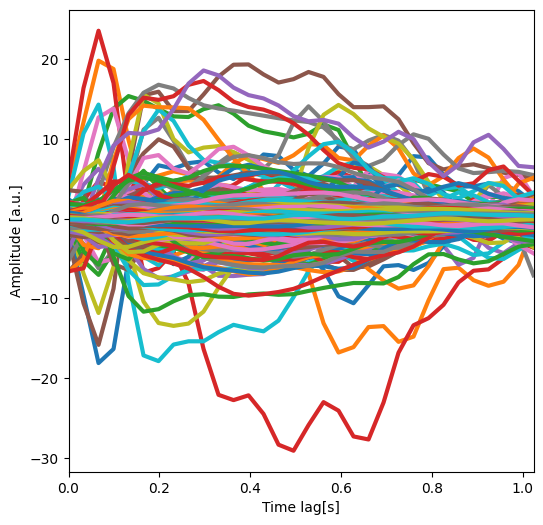

In [61]:
trf.regularization
trf.plot();

In [65]:
y_pred, r = trf.predict(X, y, average=False)

(array([117., 131., 102.,  62.,  41.,  23.,  17.,   4.,   2.,   1.]),
 array([0.02563952, 0.04960774, 0.07357596, 0.09754418, 0.1215124 ,
        0.14548062, 0.16944884, 0.19341705, 0.21738527, 0.24135349,
        0.26532171]),
 <BarContainer object of 10 artists>)

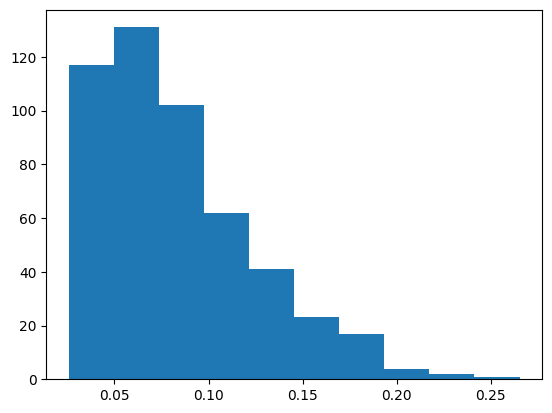

In [67]:
plt.hist(r)